In [6]:
import os
from os.path import isfile, join, isdir
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import ConcatDataset

from chord_recognition.dataset import FrameLabelDataset, make_frame_df
from chord_recognition.utils import read_csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
sns.set(style="whitegrid")

In [7]:
# https://www.music-ir.org/mirex/wiki/2020:Audio_Chord_Estimation
maj_chords = set(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
min_chords = set([c + 'm' for c in maj_chords])

seventh_labels = ['maj7', 'min7', '7']
seventh_chords = set([c + l for l in seventh_labels for c in list(maj_chords)])

inversions_labels = ['/3', 'min/b3', '/5', 'min/5']
inversions_chords = set([c + l for l in inversions_labels for c in list(maj_chords)])

seventh_inversions_labels = ['maj7/3', 'min7/b3', '7/3', 'maj7/5', 'min7/5', '7/5', 'maj7/7', 'min7/b7', '7/b7']

In [8]:
def build_dataset(mypath, sep=' '):
    datasets = []
    dirs = [f for f in os.listdir(mypath) if isdir(join(mypath, f))]
    for root, dirs, filenames in os.walk(mypath):
        for file_name in filenames:
            file_path = join(root, file_name)
            if isfile(file_path) and file_path.endswith('.lab'):
                chords_df = read_csv(file_path, sep=sep)
                datasets.append(chords_df)
                
    chords_df = pd.concat(datasets)
    chords_df.columns = ['start', 'end', 'label']
    return chords_df

def build_file_dataset(file_path, sep=' '):
    chords_df = pd.DataFrame()
    if isfile(file_path) and file_path.endswith('.lab'):
        chords_df = read_csv(file_path, sep=sep)
    chords_df.columns = ['start', 'end', 'label']
    return chords_df

def mark_vocabulary(label):
    if label in maj_chords:
        return 'maj'
    elif label in min_chords:
        return 'min'
    elif label in seventh_chords:
        return 'seventh'
    elif label in inversions_chords:
        return 'inv'
    elif label == 'N':
        return 'N'
    else:
        return 'other'

In [9]:
def preprocess_chords(df):
    chords_df = df.copy()
    # For details, see https://www.music-ir.org/mirex/wiki/2020:Audio_Chord_Estimation
    chords_df['label'] = chords_df.label.str.replace('Db', 'C#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Eb', 'D#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Gb', 'F#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Ab', 'G#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Bb', 'A#', regex=False)
    
    chords_df['label'] = chords_df.label.str.replace('C:maj', 'C', regex=False)
    chords_df['label'] = chords_df.label.str.replace('C#:maj', 'C#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('D:maj', 'D', regex=False)
    chords_df['label'] = chords_df.label.str.replace('D#:maj', 'D#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('E:maj', 'E', regex=False)
    chords_df['label'] = chords_df.label.str.replace('F:maj', 'F', regex=False)
    chords_df['label'] = chords_df.label.str.replace('F#:maj', 'F#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('G:maj', 'G', regex=False)
    chords_df['label'] = chords_df.label.str.replace('G#:maj', 'G#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('A:maj', 'A', regex=False)
    chords_df['label'] = chords_df.label.str.replace('A#:maj', 'A#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('B:maj', 'B', regex=False)
    
    chords_df['label'] = chords_df.label.str.replace(':maj7', 'maj7', regex=False)
    chords_df['label'] = chords_df.label.str.replace(':min7', 'min7', regex=False)
    chords_df['label'] = chords_df.label.str.replace(':min', 'm', regex=True)
    chords_df['label'] = chords_df.label.str.replace(':7', '7', regex=True)
    
    chords_df['vocab'] = chords_df.label.apply(lambda x: mark_vocabulary(x))
    return chords_df

In [10]:
def chord_distribution(df, title='Chord distribution'):
    print(df.groupby('vocab').size() / len(df))
    ax = sns.countplot(x="vocab", hue='vocab', data=df, dodge=False).set_title(title)

In [11]:
beatles_df = build_dataset('data/beatles/chordlabs/')
# queen_df = build_dataset('data/queen/chordlabs/', sep='\t')
# cking_df = build_dataset('data/carole_king/', sep='\t')
chords_df = beatles_df#pd.concat([beatles_df, queen_df])

vocab
N          0.027275
inv        0.041667
maj        0.573396
min        0.141516
other      0.132675
seventh    0.083470
dtype: float64


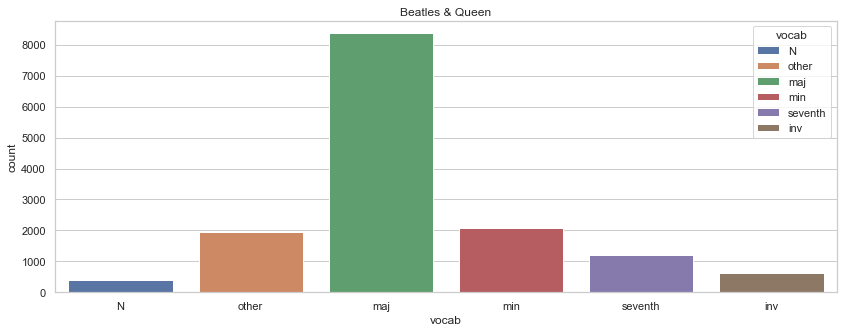

In [12]:
chords_df = preprocess_chords(chords_df)
chord_distribution(chords_df, 'Beatles & Queen')

vocab
N          0.017260
inv        0.027188
maj        0.634642
min        0.202077
other      0.079120
seventh    0.039713
dtype: float64


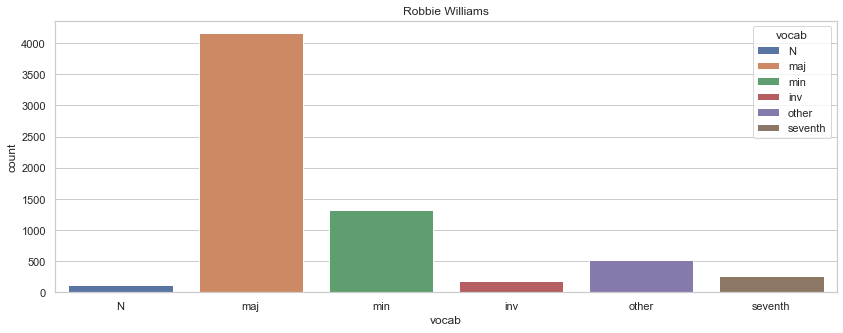

In [13]:
rwilliams_df = build_dataset('data/robbie_williams/chordlabs/', sep='\t')
df = preprocess_chords(rwilliams_df)
chord_distribution(df, 'Robbie Williams')

vocab
N          0.016949
maj        0.677966
min        0.296610
seventh    0.008475
dtype: float64


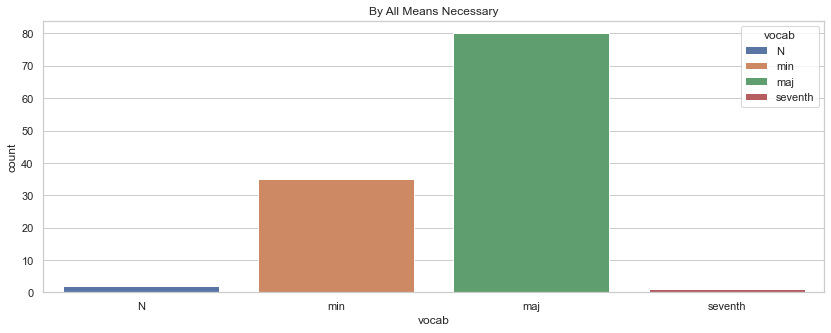

In [14]:
df = build_file_dataset("data/robbie_williams/chordlabs/2000-Sing When You're Winning/11-By All Means Necessary.lab", sep='\t')
df = preprocess_chords(df)
chord_distribution(df, 'By All Means Necessary')

In [15]:
df.groupby('label').nunique().sort_values('start', ascending=False)

,start,end,label,vocab
label,,,,
Em,21,21,1,1
A,20,20,1,1
B,15,15,1,1
C,13,13,1,1
D,13,13,1,1
G,11,11,1,1
E,6,6,1,1
Am,5,5,1,1
Dm,4,4,1,1


In [16]:
chords_df[chords_df.label.isin(list(maj_chords) + list(min_chords))].groupby('label').nunique().sort_values('start', ascending=False)
#chords_df.groupby('label').nunique().sort_values('start', ascending=False)

,start,end,label,vocab
label,,,,
A,1567,1566,1,1
G,1385,1384,1,1
D,1352,1351,1,1
E,1038,1038,1,1
C,964,966,1,1
B,503,503,1,1
F,489,489,1,1
Am,365,365,1,1
Em,336,336,1,1


In [17]:
beatles = FrameLabelDataset(audio_dir='data/beatles/mp3s-32k/',
                            ann_dir='data/beatles/chordlabs/',
                            window_size=8192, hop_length=4096)
queen = FrameLabelDataset(audio_dir='data/queen/mp3/',
                          ann_dir='data/queen/chordlabs/',
                          window_size=8192, hop_length=4096)

In [18]:
df = pd.concat(
    [pd.DataFrame(beatles.labels, columns=('label',)),
     pd.DataFrame(queen.labels, columns=('label',))])
df = df[df.label.isin(list(maj_chords) + list(min_chords) + ['N'])]
df['start'] = 0

In [19]:
augmented_df = pd.read_csv('data/augmented/augmented_semitone.csv', names=('label',))
augmented_df['start'] = 0

In [20]:
etd = pd.concat([df, augmented_df])

<AxesSubplot:xlabel='label', ylabel='count'>

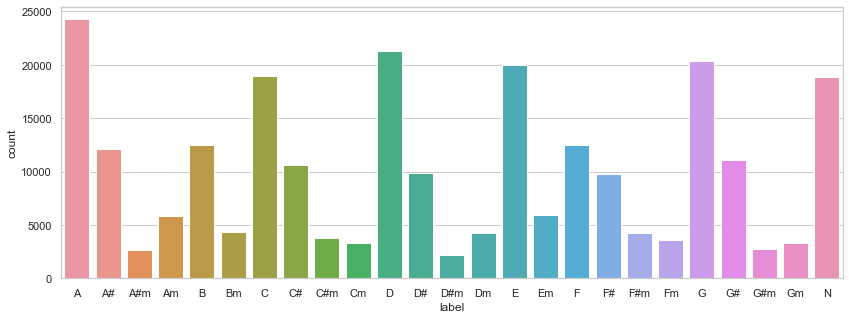

In [21]:
sns.countplot('label', data=etd.sort_values(['label']))

<AxesSubplot:xlabel='label', ylabel='count'>

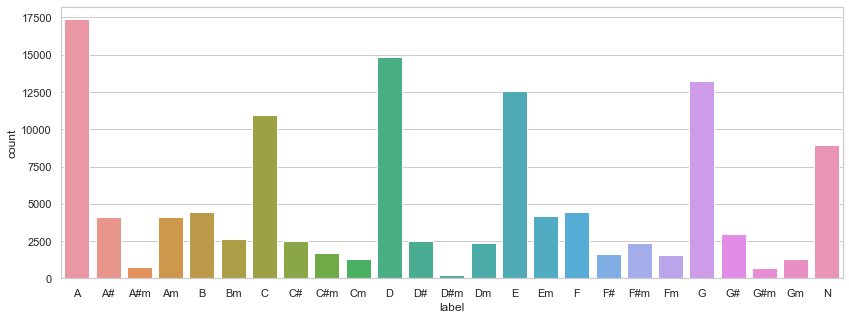

In [22]:
sns.countplot('label', data=df.sort_values(['label']))

<AxesSubplot:xlabel='label', ylabel='count'>

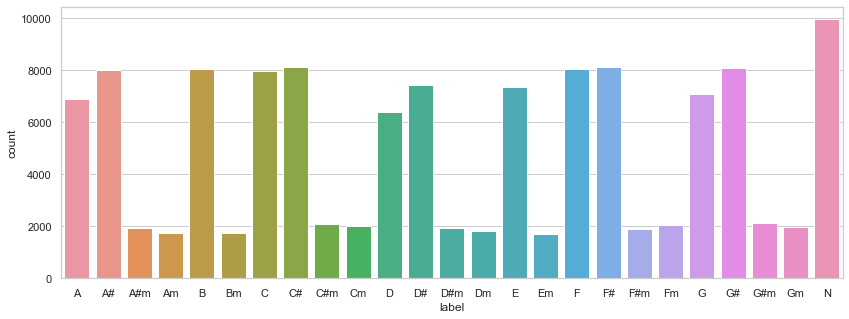

In [23]:
sns.countplot('label', data=augmented_df.sort_values(['label']))